## Import Packages

In [1]:
import os
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools
import rdkit.Chem.Fragments as Fragments
from rdkit.Chem import MACCSkeys
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.fnn_models import FCNNBtachModel as Model

## Curate Dataset

In [2]:
infile = "../data/combined_training_datasets_unique.sdf"
name = os.path.splitext(os.path.basename(infile))[0]

all_df = PandasTools.LoadSDF(infile)
all_df.head()

,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x7f2d4808dc40>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x7f2c3c15f530>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x7f2c3c15e260>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x7f2c3c15eb90>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x7f2c3c15d8c0>


In [3]:
patterns = []
for patstr in dir(Chem.Fragments):
    if patstr.startswith("fr"):
        patterns.append(patstr)
print(f"Number of fragment patterns: {len(patterns)}")

PATTERNS = [getattr(Fragments, patstr) for patstr in patterns]

def featurize(mol):
    counts = [pattern(mol) for pattern in PATTERNS]
    return counts

X = []
Y = []

for idx, row in all_df.iterrows():
    x = featurize(row["ROMol"])
    X.append(x)
    Y.append(row["pKa"])
X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float)
Y = np.where(Y<7, 1, 0).reshape(-1, 1) # binary label

nsamples = X.shape[0]
ndim = X.shape[1]

Number of fragment patterns: 85


## Hyperparameters

In [4]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

datadir = "."
ratio = 0.1
batch_size= 256
epochs = 50
lr = 5e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

## Split dataset

In [5]:
def random_split(X, Y, ratio):
    nsamples = X.shape[0]
    val_size = int(nsamples*ratio)
    val_indices = np.random.choice(nsamples, val_size, replace=False)
    train_indices = set(range(nsamples)) - set(val_indices.tolist())
    train_indices = list(train_indices)
    X_train, Y_train = X[train_indices], Y[train_indices]
    X_test, Y_test = X[val_indices], Y[val_indices]
    return (X_train, Y_train), (X_test, Y_test)

(X_train, Y_train), (X_test, Y_test) = random_split(X, Y, ratio)

In [6]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

## Model

In [7]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = torch.sigmoid(model(x))
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = torch.sigmoid(model(x))
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [8]:
model = Model(ndim, hidden_dims=[100, 50, 20])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.BCELoss() # binary cross entropy

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

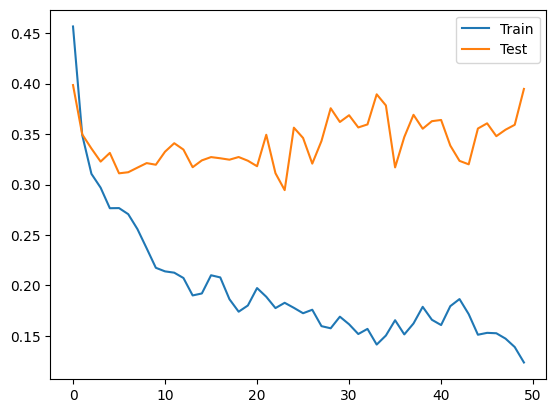

In [9]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

In [10]:
model.eval()
with torch.no_grad():
    truth = Y_test.to(device)
    pred = torch.sigmoid(model(X_test.to(device)))
    l = nn.BCELoss()(pred, truth)
    print(l)

tensor(0.3970)


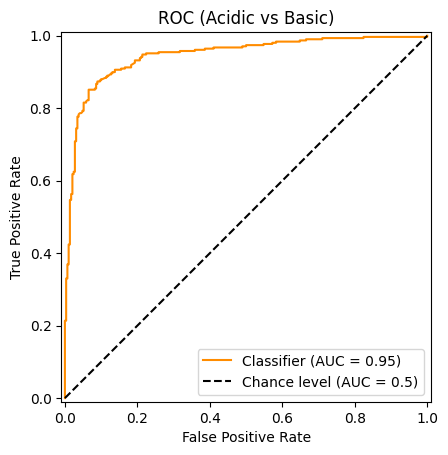

In [11]:
display = RocCurveDisplay.from_predictions(
    truth.cpu().numpy().reshape(-1).astype(int),
    pred.cpu().numpy().reshape(-1),
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC (Acidic vs Basic)",
)

In [12]:
cutoff = 0.50
mtx = confusion_matrix(truth.cpu().numpy().reshape(-1), pred.cpu().numpy().reshape(-1)>cutoff)
tn, fp, fn, tp = mtx.ravel()
print(f"Accuracy: {(tn+tp)/(tn+fp+fn+tp)*100:.2f}%")
print(f"Confusion matrix: {os.linesep} {mtx}")

Accuracy: 88.98%
Confusion matrix: 
 [[264  26]
 [ 40 269]]
